In [31]:
import os
import sys
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, brier_score_loss
)

# modules
from src.config import (
    OUTPUT_DIR,
    PROCESSED_DIR,
    RANDOM_SEED
)

# vis config 
plt.style.use('default')
sns.set_palette("husl")
FIGSIZE = (10, 6)
FIGSIZE_SMALL = (8, 5)

In [32]:
print("=" * 80)
print("LOADING PIPELINE A DATA")
print("=" * 80)

# load processed data
X_train_A = np.load(PROCESSED_DIR / 'X_train_A.npy')
X_test_A = np.load(PROCESSED_DIR / 'X_test_A.npy')
y_train = np.load(PROCESSED_DIR / 'y_train.npy')
y_test = np.load(PROCESSED_DIR / 'y_test.npy')

# load feature names
with open(PROCESSED_DIR / 'feature_names_A.txt', 'r') as f:
    feature_names_A = f.read().split(r'\n')

# validation
print(f"\nShapes:")
print(f"  X_train_A: {X_train_A.shape}")
print(f"  X_test_A:  {X_test_A.shape}")
print(f"  y_train:   {y_train.shape}")
print(f"  y_test:    {y_test.shape}")

print(f"\nFeatures ({len(feature_names_A)}):")
print(f"  {feature_names_A}")

# check for missing values
print(f"\nData Quality:")
print(f"  X_train_A missing: {np.isnan(X_train_A).sum()}")
print(f"  X_test_A missing:  {np.isnan(X_test_A).sum()}")

# class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nClass Distribution (Training):")
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_train)*100:.2f}%)")

print("\nPipeline A data loaded successfully")

LOADING PIPELINE A DATA

Shapes:
  X_train_A: (20000, 8)
  X_test_A:  (5000, 8)
  y_train:   (20000,)
  y_test:    (5000,)

Features (8):
  ['Age', 'Income', 'CreditScore', 'LoanAmount', 'EmploymentYears', 'NumDependents', 'DebtToIncome', 'EducationLevel']

Data Quality:
  X_train_A missing: 0
  X_test_A missing:  0

Class Distribution (Training):
  Class 0: 13,137 (65.69%)
  Class 1: 6,863 (34.31%)

Pipeline A data loaded successfully


In [33]:
print("=" * 80)
print("LOADING PIPELINE B DATA")
print("=" * 80)

# load processed data
X_train_B = np.load(PROCESSED_DIR / 'X_train_B.npy')
X_test_B = np.load(PROCESSED_DIR / 'X_test_B.npy')

# load feature names
with open(PROCESSED_DIR / 'feature_names_B.txt', 'r') as f:
    feature_names_B = f.read().split(r'\n')

# validation
print(f"\nShapes:")
print(f"  X_train_B: {X_train_B.shape}")
print(f"  X_test_B:  {X_test_B.shape}")

print(f"\nFeatures ({len(feature_names_B)}):")
for i, feat in enumerate(feature_names_B):
    print(f"  {i+1:2d}. {feat}")

# check for missing values
print(f"\nData Quality:")
print(f"  X_train_B missing: {np.isnan(X_train_B).sum()}")
print(f"  X_test_B missing:  {np.isnan(X_test_B).sum()}")

print("\nPipeline B data loaded successfully")

LOADING PIPELINE B DATA

Shapes:
  X_train_B: (20000, 14)
  X_test_B:  (5000, 14)

Features (14):
   1. Age
   2. Income
   3. CreditScore
   4. LoanAmount
   5. EmploymentYears
   6. NumDependents
   7. DebtToIncome
   8. EducationLevel
   9. FavoriteColor_Green
  10. FavoriteColor_Red
  11. FavoriteColor_Yellow
  12. Hobby_Reading
  13. Hobby_Sports
  14. Hobby_Traveling

Data Quality:
  X_train_B missing: 0
  X_test_B missing:  0

Pipeline B data loaded successfully


In [34]:
print("=" * 80)
print("CROSS-VALIDATION SETUP")
print("=" * 80)

# create stratified k-fold
N_SPLITS = 5
RANDOM_STATE = 42

cv = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

# verify stratification
print(f"\nCross-Validation Configuration:")
print(f"  Strategy: Stratified K-Fold")
print(f"  Splits: {N_SPLITS}")
print(f"  Shuffle: True")
print(f"  Random State: {RANDOM_STATE}")

# check fold class distribution
print(f"\nVerifying stratification:")
fold_distributions = []
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_A, y_train)):
    y_fold = y_train[val_idx]
    default_rate = (y_fold == 1).sum() / len(y_fold)
    fold_distributions.append(default_rate)
    print(f"  Fold {fold_idx + 1}: {default_rate*100:.2f}% default rate")

print(f"\nStratification Quality:")
print(f"  Mean default rate: {np.mean(fold_distributions)*100:.2f}%")
print(f"  Std default rate:  {np.std(fold_distributions)*100:.3f}%")
print(f"  Target (from train): {(y_train==1).sum()/len(y_train)*100:.2f}%")

print("\nCross-validation setup complete")

CROSS-VALIDATION SETUP

Cross-Validation Configuration:
  Strategy: Stratified K-Fold
  Splits: 5
  Shuffle: True
  Random State: 42

Verifying stratification:
  Fold 1: 34.30% default rate
  Fold 2: 34.30% default rate
  Fold 3: 34.33% default rate
  Fold 4: 34.33% default rate
  Fold 5: 34.33% default rate

Stratification Quality:
  Mean default rate: 34.31%
  Std default rate:  0.012%
  Target (from train): 34.31%

Cross-validation setup complete


In [37]:
print("=" * 80)
print("EVALUATION METRICS SETUP")
print("=" * 80)

all_results = {}

# define scoring metrics for cross-validation
SCORING_METRICS = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy'
}

print("\nMetrics for evaluation:")
print("  Primary:   ROC-AUC (threshold-independent, handles imbalance)")
print("  Secondary: F1, Precision, Recall (threshold-dependent)")
print("  Additional: Accuracy, Brier Score (calibration)")

# helper function for consistent evaluation
def evaluate_model(
    model,
    X_train, y_train,
    X_test, y_test,
    cv,
    model_name: str,
    pipeline_name: str
) -> Dict:
    """
    Comprehensive model evaluation with CV and test set metrics.
    
    Returns:
        Dictionary with CV scores, test scores, and predictions
    """
    
    # CV
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=SCORING_METRICS,
        return_train_score=False,
        n_jobs=-1
    )
    
    # test set predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # test set metrics
    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'accuracy': (y_pred == y_test).mean(),
        'brier': brier_score_loss(y_test, y_pred_proba)
    }
    
    results = {
        'model_name': model_name,
        'pipeline': pipeline_name,
        'cv_scores': cv_results,
        'test_metrics': test_metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }
    
    return results


EVALUATION METRICS SETUP

Metrics for evaluation:
  Primary:   ROC-AUC (threshold-independent, handles imbalance)
  Secondary: F1, Precision, Recall (threshold-dependent)
  Additional: Accuracy, Brier Score (calibration)


In [39]:
print("=" * 80)
print("MODEL 1/8: DUMMY CLASSIFIER - PIPELINE A")
print("=" * 80)

# create and train dummy classifier
dummy_A = DummyClassifier(strategy='stratified', random_state=RANDOM_SEED)
dummy_A.fit(X_train_A, y_train)

# evaluate
results_dummy_A = evaluate_model(
    model=dummy_A,
    X_train=X_train_A,
    y_train=y_train,
    X_test=X_test_A,
    y_test=y_test,
    cv=cv,
    model_name='DummyClassifier',
    pipeline_name='A'
)

# store results
all_results['dummy_A'] = results_dummy_A

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_dummy_A['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_dummy_A['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

print("\nModel 1/8 complete")

MODEL 1/8: DUMMY CLASSIFIER - PIPELINE A

Cross-Validation Results (5-fold):
  roc_auc     : 0.5016 ± 0.0083
  f1          : 0.3451 ± 0.0108
  precision   : 0.3452 ± 0.0108
  recall      : 0.3450 ± 0.0108
  accuracy    : 0.5506 ± 0.0075

Test Set Results:
  roc_auc     : 0.5116
  f1          : 0.3621
  precision   : 0.3675
  recall      : 0.3568
  accuracy    : 0.5574
  brier       : 0.4426

Model 1/8 complete


In [40]:
print("=" * 80)
print("MODEL 2/8: DUMMY CLASSIFIER - PIPELINE B")
print("=" * 80)

# create and train dummy classifier
dummy_B = DummyClassifier(strategy='stratified', random_state=RANDOM_SEED)
dummy_B.fit(X_train_B, y_train)

# evaluate
results_dummy_B = evaluate_model(
    model=dummy_B,
    X_train=X_train_B,
    y_train=y_train,
    X_test=X_test_B,
    y_test=y_test,
    cv=cv,
    model_name='DummyClassifier',
    pipeline_name='B'
)

# store results
all_results['dummy_B'] = results_dummy_B

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_dummy_B['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_dummy_B['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

print("\nModel 2/8 complete")

MODEL 2/8: DUMMY CLASSIFIER - PIPELINE B

Cross-Validation Results (5-fold):
  roc_auc     : 0.5016 ± 0.0083
  f1          : 0.3451 ± 0.0108
  precision   : 0.3452 ± 0.0108
  recall      : 0.3450 ± 0.0108
  accuracy    : 0.5506 ± 0.0075

Test Set Results:
  roc_auc     : 0.5116
  f1          : 0.3621
  precision   : 0.3675
  recall      : 0.3568
  accuracy    : 0.5574
  brier       : 0.4426

Model 2/8 complete


DUMMY CLASSIFIER ANALYSIS


NameError: name 'FIGURES_DIR' is not defined

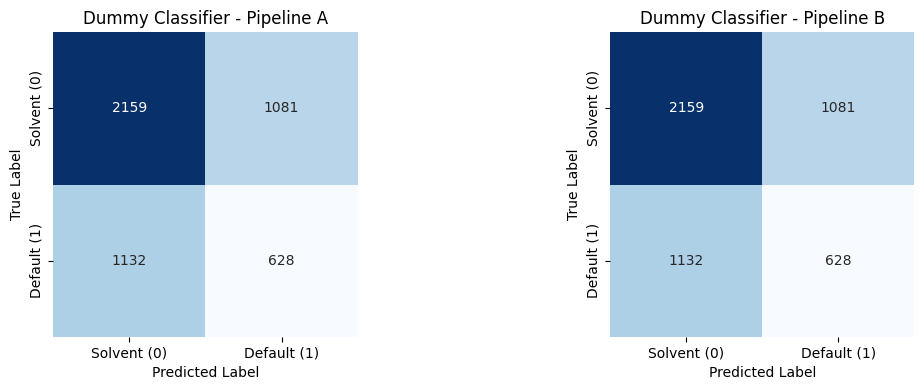

In [41]:
print("=" * 80)
print("DUMMY CLASSIFIER ANALYSIS")
print("=" * 80)

# confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, (key, pipeline) in enumerate([('dummy_A', 'A'), ('dummy_B', 'B')]):
    results = all_results[key]
    cm = confusion_matrix(y_test, results['y_pred'])
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[idx],
        cbar=False,
        square=True
    )
    axes[idx].set_title(f'Dummy Classifier - Pipeline {pipeline}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_xticklabels(['Solvent (0)', 'Default (1)'])
    axes[idx].set_yticklabels(['Solvent (0)', 'Default (1)'])

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_dummy_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion matrices saved to {FIGURES_DIR / '03_dummy_confusion_matrices.png'}")